In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [3]:
num_cols = ['age','trestbps','chol','thalach','oldpeak','ca']
cat_cols = ['sex','cp','fbs','restecg','exang','slope','thal']

In [4]:
y.value_counts()

num
0      164
1       55
2       36
3       35
4       13
Name: count, dtype: int64

In [5]:
X['result']=y

##EDA

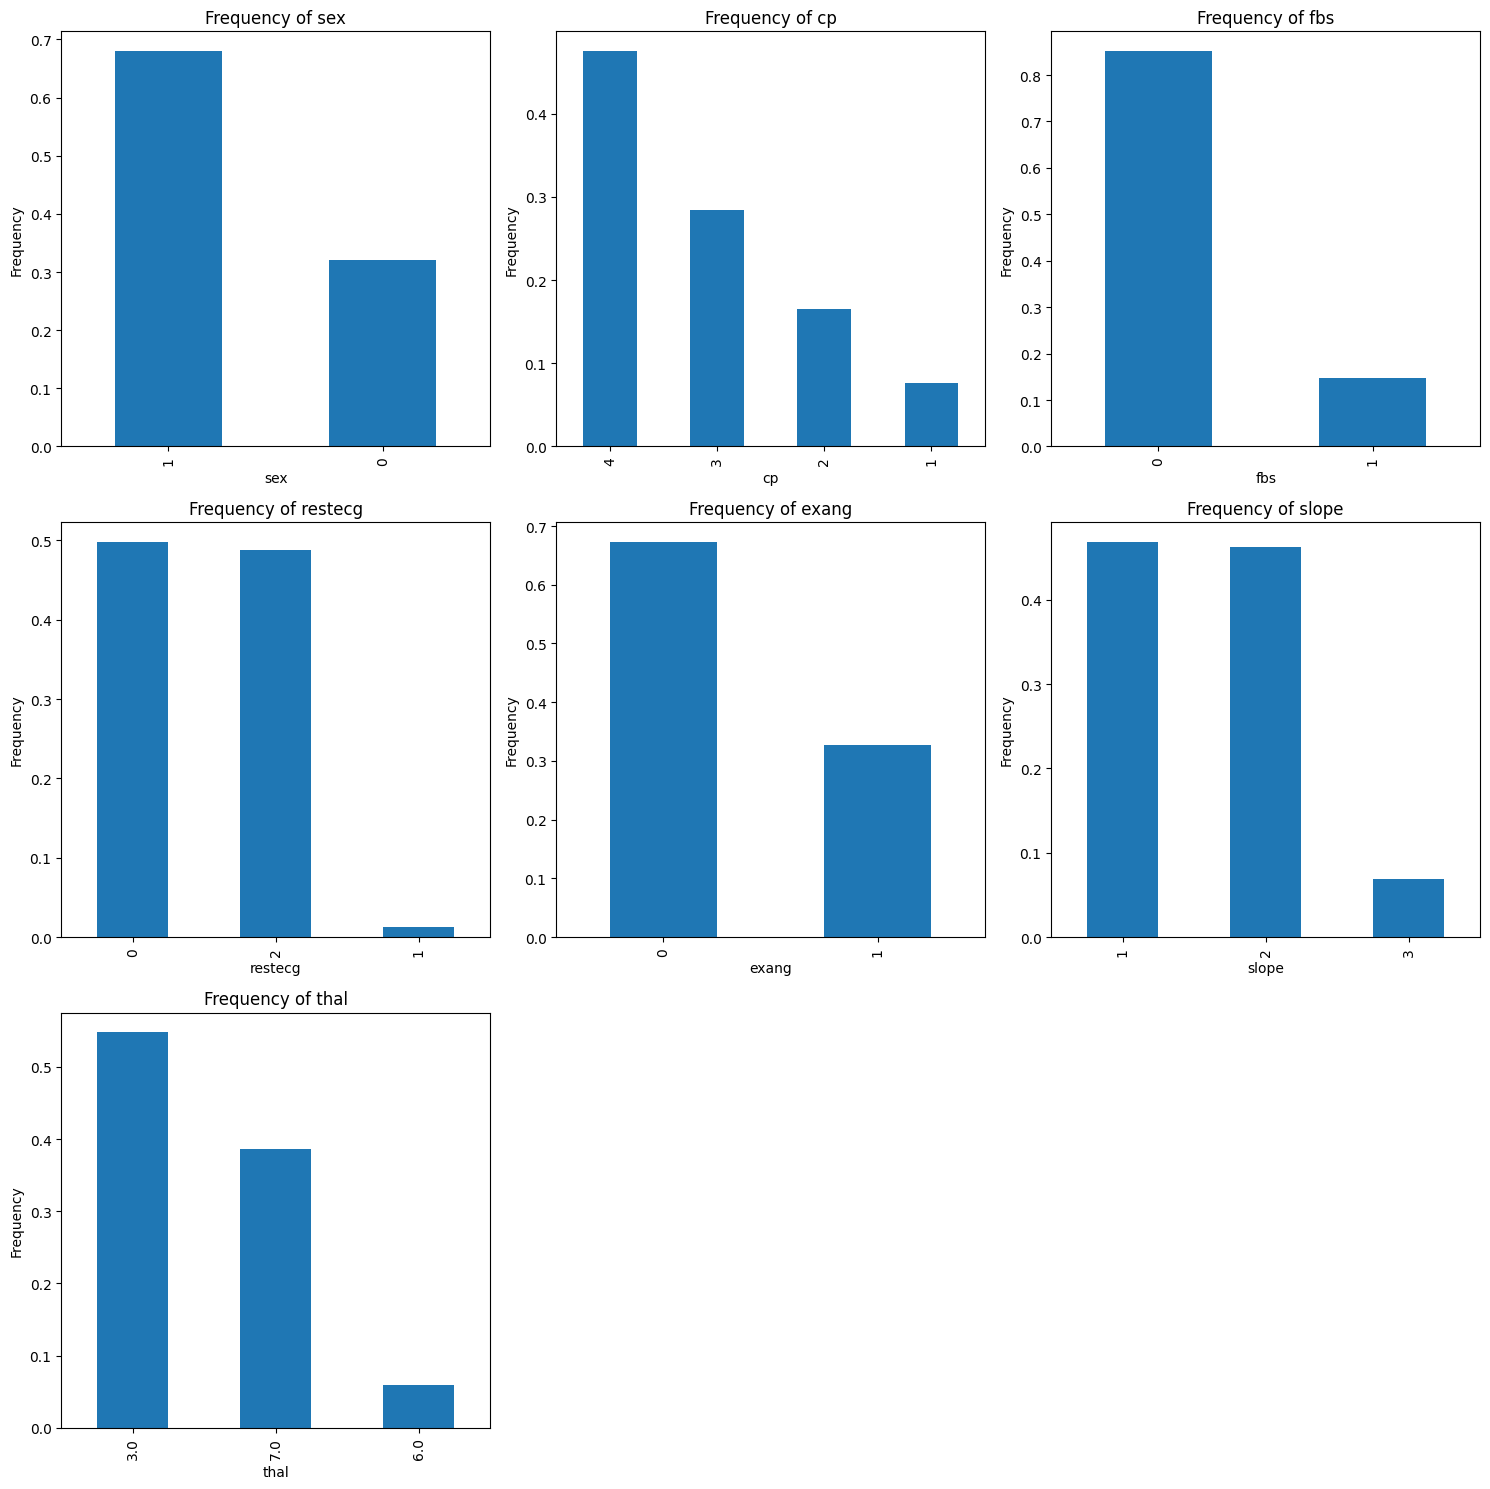

In [90]:
# Categorical values
import matplotlib.pyplot as plt

cat = X[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']]

# Calculate the number of rows needed for 3 columns
num_plots = len(cat.columns)
num_rows = (num_plots + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, col in enumerate(cat.columns):
    valuecounts = X[col].value_counts()
    freq = valuecounts / X[col].shape[0]
    ax = axes[i]
    freq.plot(kind='bar', ax=ax)
    ax.set_title(f'Frequency of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Hide any unused axes if the number of plots is not a multiple of 3
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


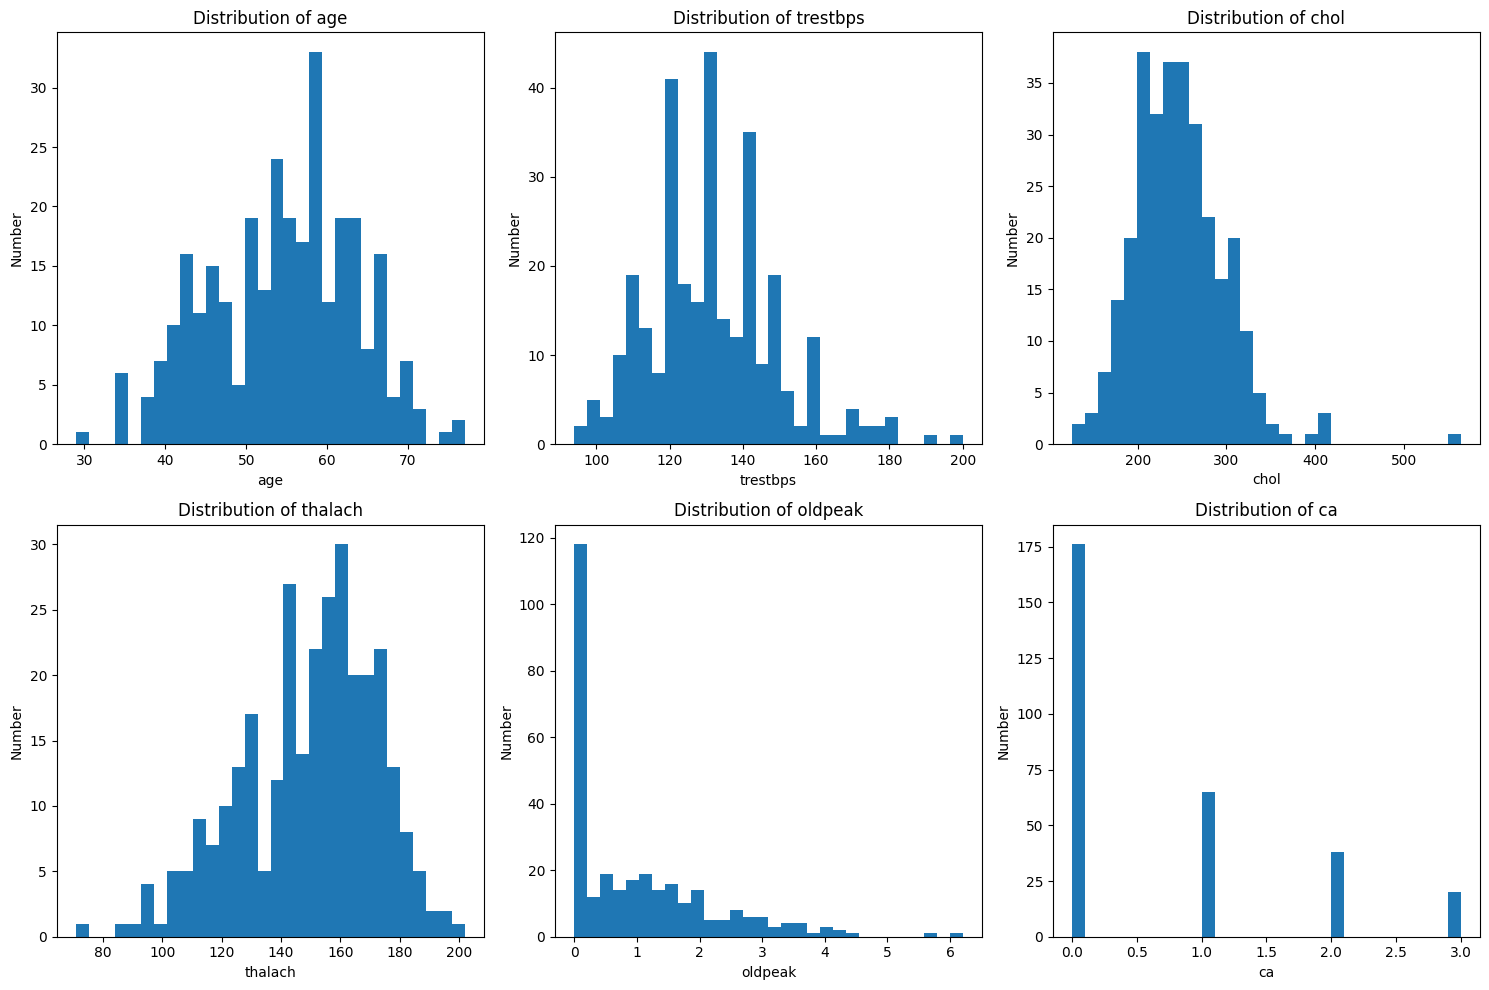

In [91]:
import matplotlib.pyplot as plt

cont = X[['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']]

# Calculate the number of rows needed for 3 columns
num_plots = len(cont.columns)
num_rows = (num_plots + 2) // 3  # +2 ensures that we handle the remainder correctly when dividing

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Create histograms for each column
for i, col in enumerate(cont.columns):
    axes[i].hist(X[col], bins=30)  # Adjust number of bins and color as needed
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Number')

# Hide any unused axes if the number of plots is not a multiple of 3
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [92]:
# Analyzing and imputing missing values
X.isna().sum()
X=X.dropna()

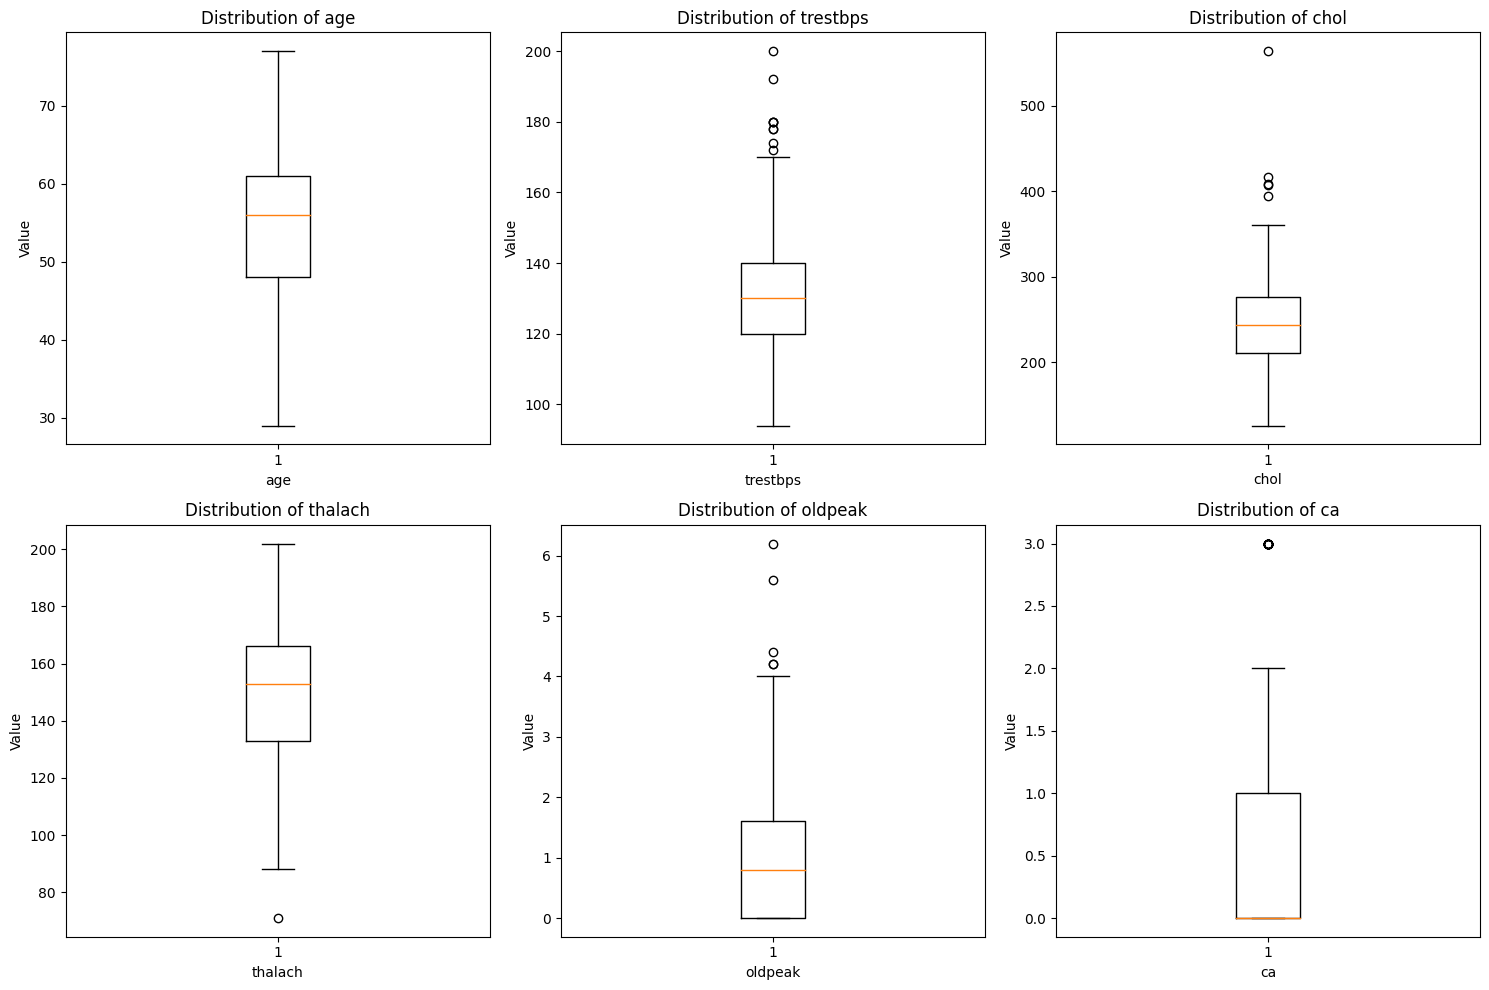

In [93]:
# Dealing with numerical feature outliers
# Create boxplots for all numerical features

# Calculate the number of rows needed for 3 columns
num_plots = len(cont.columns)
num_rows = (num_plots + 2) // 3  # +2 ensures that we handle the remainder correctly when dividing

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Create box plots for each column
for i, col in enumerate(cont.columns):
    axes[i].boxplot(X[col].dropna())  # Using dropna() to ignore missing values in boxplot
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Value')

# Hide any unused axes if the number of plots is not a multiple of 3
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [94]:
# Eliminate outliers


# Function to remove outliers based on the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

Xnew = remove_outliers(X,col)




## Classification

In [ ]:
pip install scikit-learn


In [96]:
# Prediction model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

ynew = Xnew['result']

# Convert diagnosis into a binary outcome: 1 for cancer (y == 0), 0 otherwise
ynew = (ynew == 0).astype(int)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xnew, ynew, test_size=0.2, random_state=42)

# Preprocessing steps
categorical_cols = Xnew.select_dtypes(include=['object', 'category']).columns
numerical_cols = Xnew.select_dtypes(include=['float64', 'int64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline that processes the data and then fits the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Training the model
pipeline.fit(X_train, y_train)

# Predicting the test set results
y_pred = pipeline.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)



Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        29

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



In [98]:
# Patient clustering for wellness company
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

wellness = Xnew[['age', 'sex', 'cp', 'thalach', 'exang', 'oldpeak', 'slope']]

# Identify numerical and categorical columns by names directly
numerical_cols = list(set(wellness.columns).intersection(num_cols))
categorical_cols = list(set(wellness.columns).intersection(cat_cols))

# Create a preprocessor to scale numerical data and encode categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Fit and transform the preprocessor
X_transformed = preprocessor.fit_transform(wellness)

# Apply KMeans clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_transformed)

# Predict the clusters
clusters = kmeans.predict(X_transformed)

# Add the cluster labels to the original DataFrame
wellness['Cluster'] = clusters

print(wellness)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


     age  sex  cp  thalach  exang  oldpeak  slope  Cluster
0     63    1   1      150      0      2.3      3        2
2     67    1   4      129      1      2.6      2        2
3     37    1   3      187      0      3.5      3        1
4     41    0   2      172      0      1.4      1        1
5     56    1   2      178      0      0.8      1        1
..   ...  ...  ..      ...    ...      ...    ...      ...
297   57    0   4      123      1      0.2      2        2
298   45    1   1      132      0      1.2      2        2
299   68    1   4      141      0      3.4      2        2
300   57    1   4      115      1      1.2      2        2
301   57    0   2      174      0      0.0      2        0

[277 rows x 8 columns]


<ipython-input-98-23bb8a9d174f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wellness['Cluster'] = clusters


<ipython-input-114-18db5a2547d0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num['Cluster'] = wellness['Cluster']


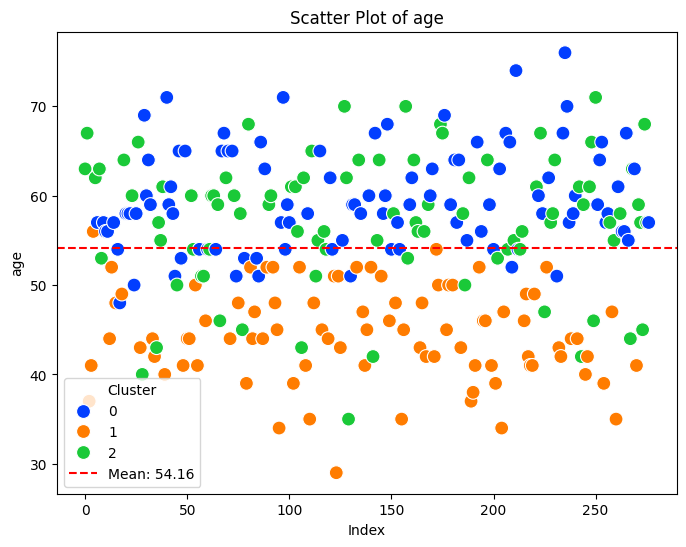

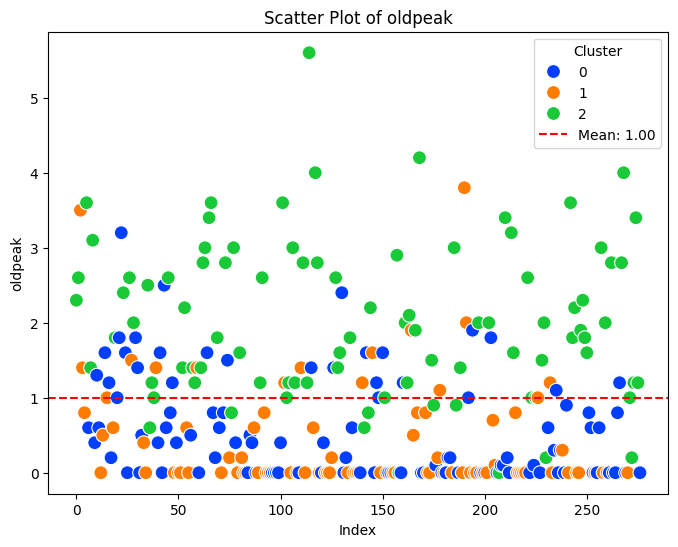

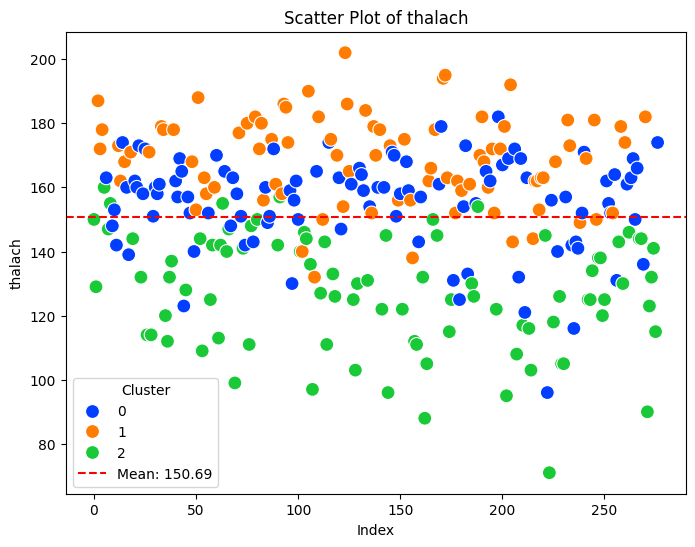

<ipython-input-114-18db5a2547d0>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ['Cluster'] = wellness['Cluster']


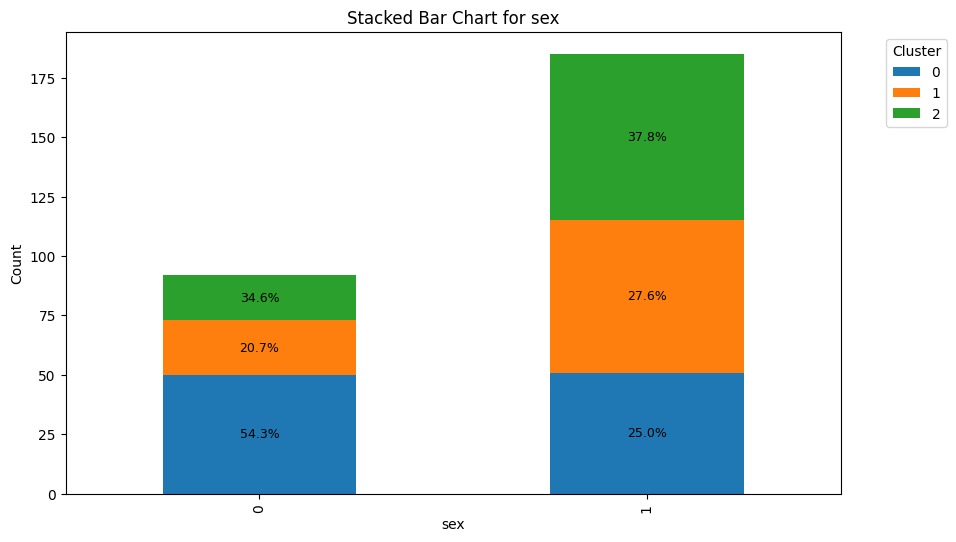

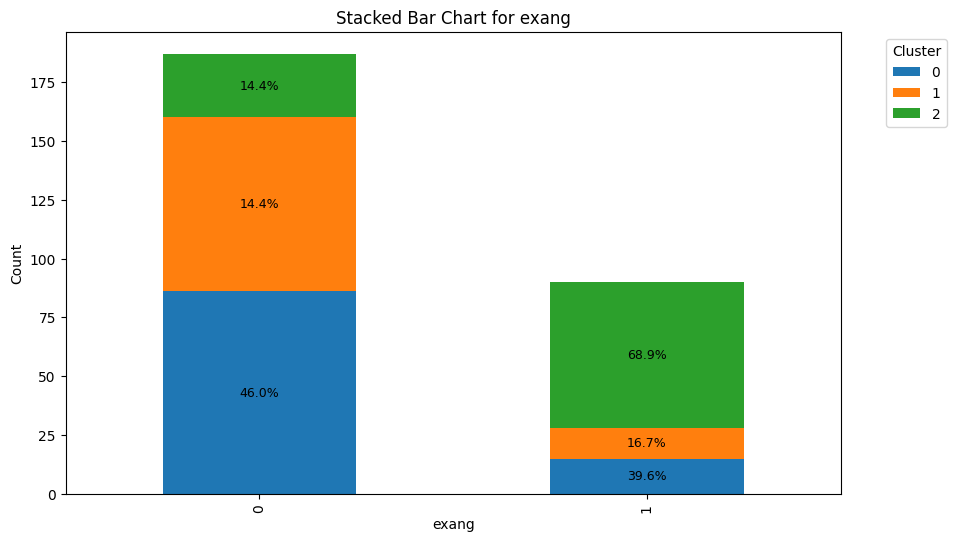

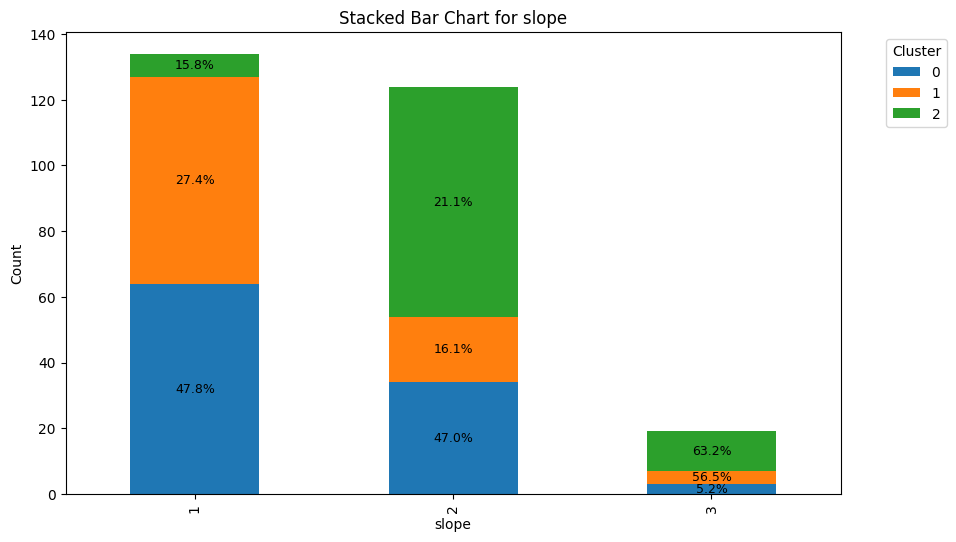

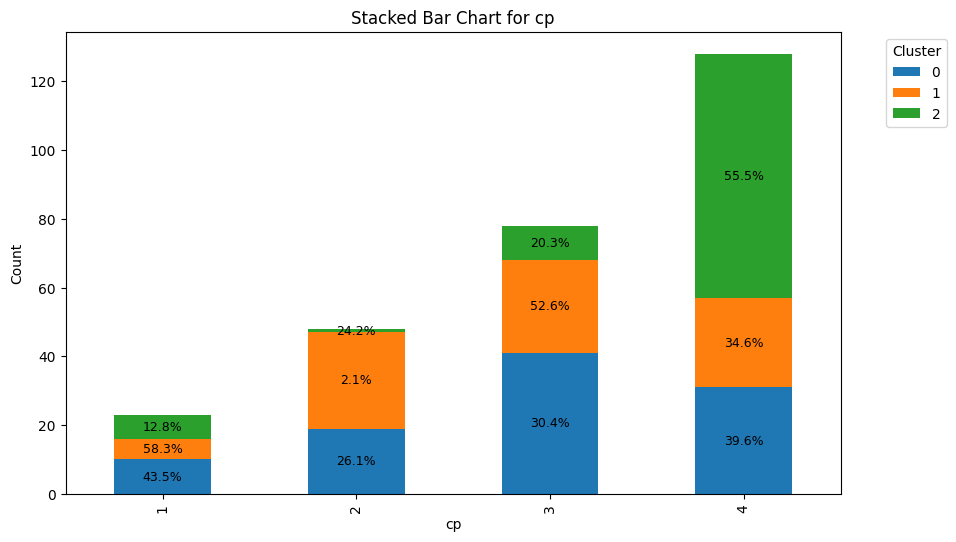

In [114]:
# wellness clustering visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

num = wellness[numerical_cols]
num['Cluster'] = wellness['Cluster']

# Define the number of clusters and their colors (extend the palette if more clusters)
palette = sns.color_palette('bright', len(num['Cluster'].unique()))

# Loop through each column (except 'Cluster')
for col in num.columns[:-1]:  # Assuming 'Cluster' is the last column
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=range(len(num)), y=num[col], hue=num['Cluster'], palette=palette, s=100)

    # Calculate and plot the mean value for the column
    mean_value = num[col].mean()
    plt.axhline(y=mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')

    # Styling
    plt.title(f'Scatter Plot of {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.legend(title='Cluster')

    plt.show()

categ = wellness[categorical_cols]
categ['Cluster'] = wellness['Cluster']



clusters = categ['Cluster'].unique()

# Loop through each categorical column (excluding 'Cluster' if present)
for col in categ.columns[categ.columns != 'Cluster']:  # Exclude the 'Cluster' column
    # Creating a cross-tabulation of counts
    ct = pd.crosstab(categ[col], categ['Cluster'])
    # Normalize the cross-tabulation to get percentages
    ct_percentage = ct.div(ct.sum(axis=1), axis=0) * 100

    # Plotting
    ax = ct.plot(kind='bar', stacked=True, figsize=(10, 6))
    ax.set_title(f'Stacked Bar Chart for {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

    # Annotate bars with percentage value
    for rect, label in zip(ax.patches, ct_percentage.values.flatten()):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
            f'{label:.1f}%', ha='center', va='center', fontsize=9
        )

    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()



In [121]:
# Patient clustering for pharmaceutical company
pharma = Xnew[['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'ca', 'thal']]

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans


# Identify numerical and categorical columns by names directly
numerical_cols = list(set(pharma.columns).intersection(num_cols))
categorical_cols = list(set(pharma.columns).intersection(cat_cols))

# Create a preprocessor to scale numerical data and encode categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Fit and transform the preprocessor
X_transformed = preprocessor.fit_transform(pharma)

# Apply KMeans clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_transformed)

# Predict the clusters
clusters = kmeans.predict(X_transformed)

# Add the cluster labels to the original DataFrame
pharma['Cluster'] = clusters

print(pharma)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


     age  sex  trestbps  chol  fbs  restecg   ca  thal  Cluster
0     63    1       145   233    1        2  0.0   6.0        0
2     67    1       120   229    0        2  2.0   7.0        1
3     37    1       130   250    0        0  0.0   3.0        2
4     41    0       130   204    0        2  0.0   3.0        2
5     56    1       120   236    0        0  0.0   3.0        2
..   ...  ...       ...   ...  ...      ...  ...   ...      ...
297   57    0       140   241    0        0  0.0   7.0        0
298   45    1       110   264    0        0  0.0   7.0        2
299   68    1       144   193    1        0  2.0   7.0        1
300   57    1       130   131    0        0  1.0   7.0        1
301   57    0       130   236    0        2  1.0   3.0        1

[277 rows x 9 columns]


<ipython-input-121-f9f2e377446b>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pharma['Cluster'] = clusters


<ipython-input-123-44df1954601e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num['Cluster'] = pharma['Cluster']


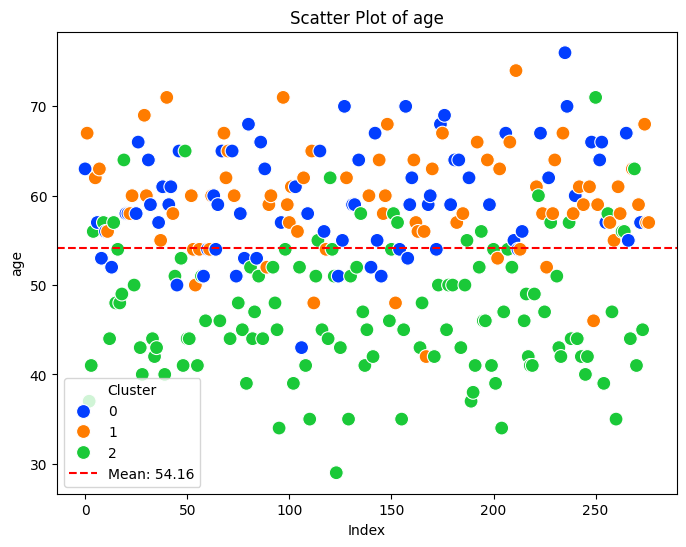

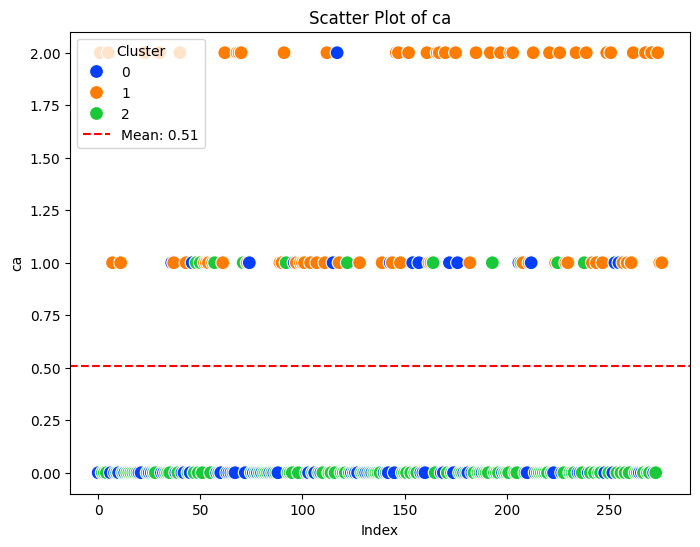

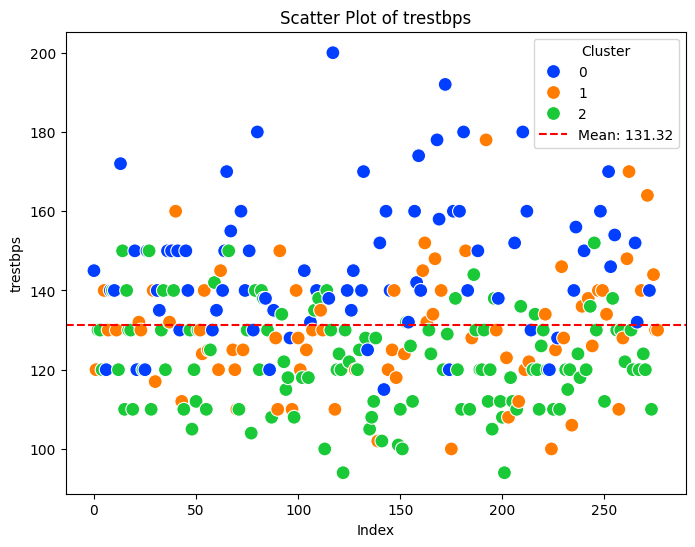

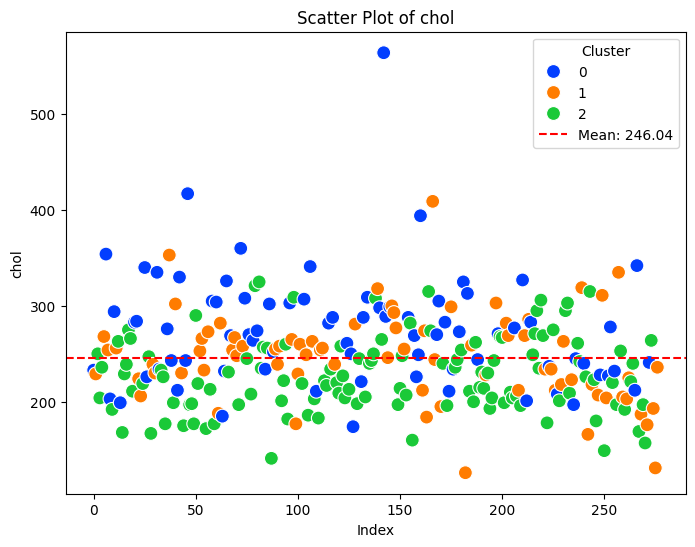

<ipython-input-123-44df1954601e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ['Cluster'] = pharma['Cluster']


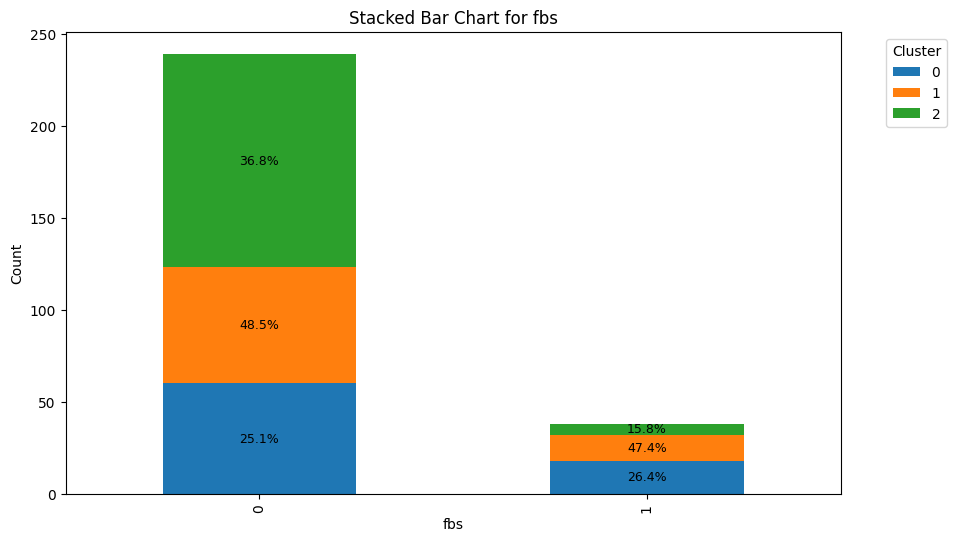

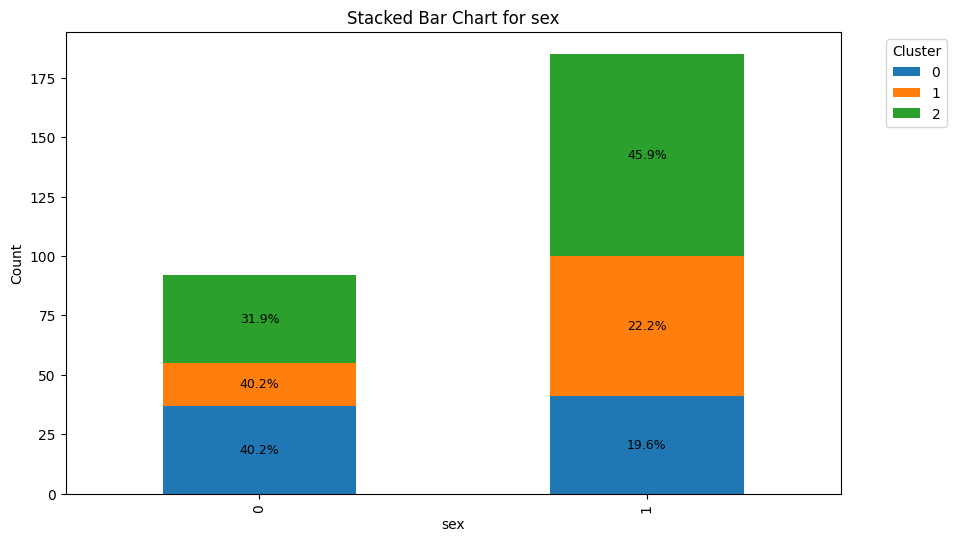

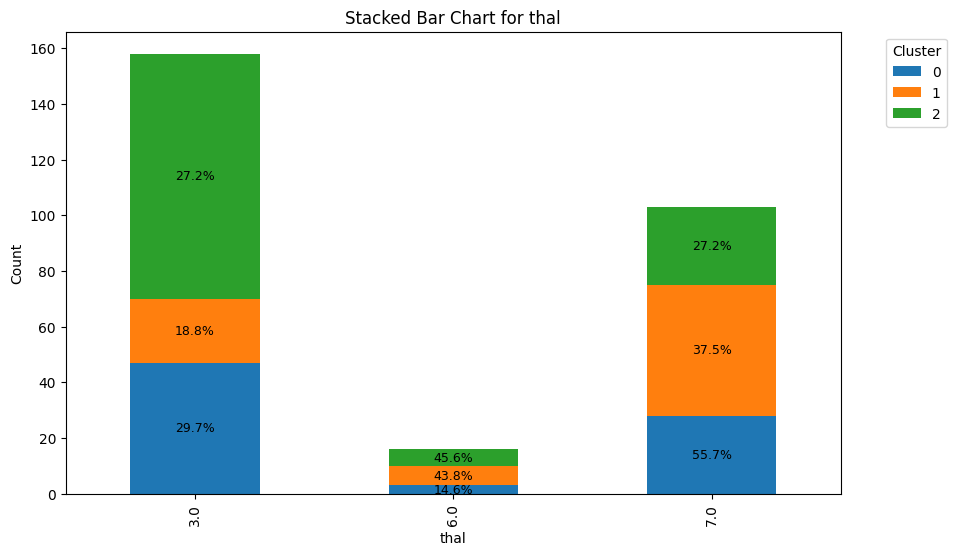

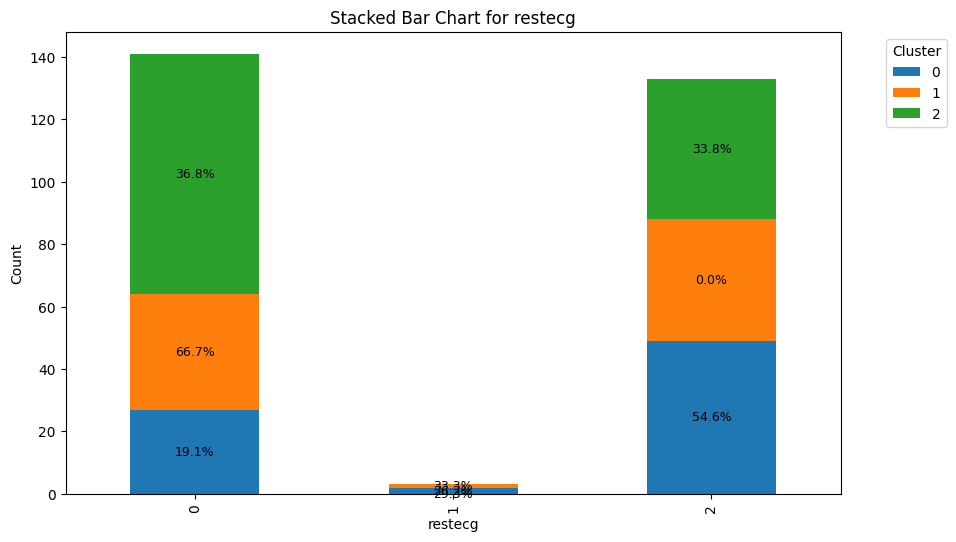

In [123]:
# visualization for pharma clustering
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

num = pharma[numerical_cols]
num['Cluster'] = pharma['Cluster']

# Define the number of clusters and their colors (extend the palette if more clusters)
palette = sns.color_palette('bright', len(num['Cluster'].unique()))

# Loop through each column (except 'Cluster')
for col in num.columns[:-1]:  # Assuming 'Cluster' is the last column
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=range(len(num)), y=num[col], hue=num['Cluster'], palette=palette, s=100)

    # Calculate and plot the mean value for the column
    mean_value = num[col].mean()
    plt.axhline(y=mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')

    # Styling
    plt.title(f'Scatter Plot of {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.legend(title='Cluster')

    plt.show()

categ = pharma[categorical_cols]
categ['Cluster'] = pharma['Cluster']



clusters = categ['Cluster'].unique()

# Loop through each categorical column (excluding 'Cluster' if present)
for col in categ.columns[categ.columns != 'Cluster']:  # Exclude the 'Cluster' column
    # Creating a cross-tabulation of counts
    ct = pd.crosstab(categ[col], categ['Cluster'])
    # Normalize the cross-tabulation to get percentages
    ct_percentage = ct.div(ct.sum(axis=1), axis=0) * 100

    # Plotting
    ax = ct.plot(kind='bar', stacked=True, figsize=(10, 6))
    ax.set_title(f'Stacked Bar Chart for {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

    # Annotate bars with percentage value
    for rect, label in zip(ax.patches, ct_percentage.values.flatten()):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
            f'{label:.1f}%', ha='center', va='center', fontsize=9
        )

    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()